In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from pref_viewing.utils import plot_imgs
from alignment.utils import get_usual_transform
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from datetime import datetime
import torch

In [23]:
transform = get_usual_transform()
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet/val", transform=transform)

transform_to_show = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
dataset_to_show = datasets.ImageFolder(f"{paths["data_path"]}/imagenet/val", transform=transform_to_show)

In [3]:
print(dataset[0][1])

0


In [4]:
def get_k_imgs(dim_rid1, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    topk_indices = sorted_indices[-k:][::-1]  # descending: highest values
    print(topk_indices)
    bottomk_indices = sorted_indices[:k] 
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

def get_kk_imgs(dim_rid1, r_idx, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    topk_indices = r_idx[sorted_indices[-k:][::-1]]  # descending: highest values
    print(topk_indices)
    bottomk_indices = r_idx[sorted_indices[:k]]
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "alexnet"
target_layer = "features.0"
model_cls = getattr(models, model_name)
model = model_cls(pretrained=True).to(device).eval()
feature_extractor = create_feature_extractor(
    model, return_nodes=[target_layer]
).to(device)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
extreme_n_imgs = 100
top_n_PCs = 10
top_save_path = f"{paths["results_path"]}/{model_name}_{target_layer}_top_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"
bottom_save_path = f"{paths["results_path"]}/{model_name}_{target_layer}_bottom_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"
p_PCs = f"{paths["results_path"]}/imagenet_val_{model_name}_{target_layer}_pca_model_1000_PCs.pkl"
#p_PCs = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/imagenet_val_alexnet_features.0_pca_model_1000_PCs.pkl"
iPCs = joblib.load(p_PCs).components_

In [8]:
top_dims = np.loadtxt(top_save_path, delimiter=',', dtype=int)
bottom_dims = np.loadtxt(bottom_save_path, delimiter=',', dtype=int)

In [72]:
dim = 3
k = 16

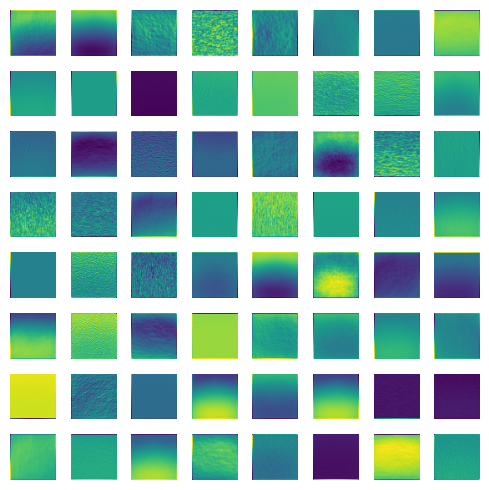

In [76]:
a = np.reshape(iPCs[dim,:], (64, 55,55))
num_channels = a.shape[0]
cols = 8
rows = int(np.ceil(num_channels / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
    if i < num_channels:
        ax.imshow(a[i], cmap='viridis')
        #ax.set_title(f"{i}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplot

plt.tight_layout()
plt.show()

In [73]:
topk_imgs_all_feats = [dataset_to_show[i][0].permute(1,2,0) for i in top_dims[dim, :k]]
bottomk_imgs_all_feats = [dataset_to_show[i][0].permute(1,2,0) for i in bottom_dims[dim, -k:]]

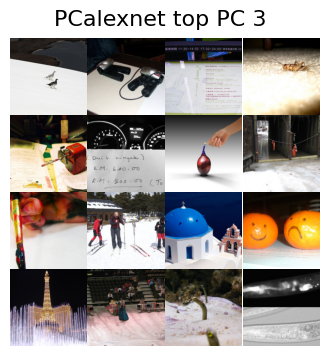

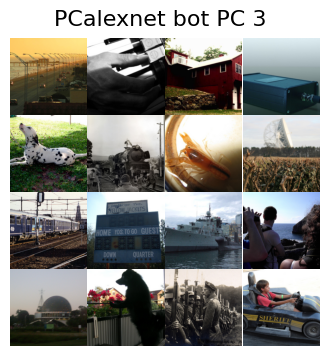

In [74]:
b = plot_imgs(topk_imgs_all_feats,title=f"PC{model_name} top PC {dim}", square_size=4)
a = plot_imgs(bottomk_imgs_all_feats,title=f"PC{model_name} bot PC {dim}", square_size=4)

In [78]:
pooling = "maxpool"
feats_path_pool = f"{paths["results_path"]}/imagenet_val_{model_name}_{target_layer}_{pooling}_features.pkl"
feats_pool = joblib.load(feats_path_pool)
PCs_path_pool = f"{paths["results_path"]}/imagenet_val_{model_name}_{target_layer}_{pooling}_pca_model_1000_PCs.pkl"
PCs_pool = joblib.load(PCs_path_pool)

In [79]:
dim_redu_pool = feats_pool@PCs_pool.components_.T
pool_topk_imgs, pool_bottomk_imgs = get_k_imgs(dim_redu_pool, dataset_to_show, k, dim)

[35819 32944 45232 34360 45220 34378 38916 20789 20564 22660 35805 39948
 22920 34381 39054 34389]


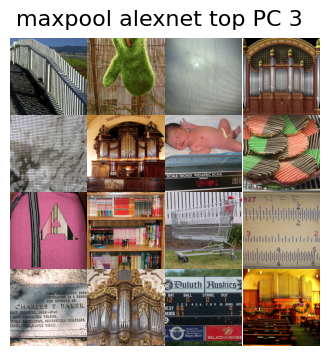

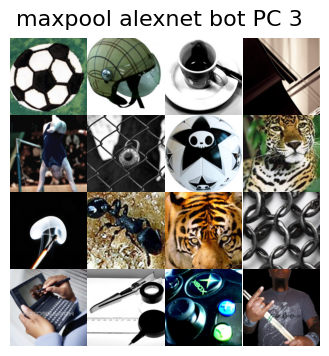

In [80]:
dfsifh = plot_imgs(pool_topk_imgs, title=f"{pooling} {model_name} top PC {dim}", square_size=4)
dsc = plot_imgs(pool_bottomk_imgs, title=f"{pooling} {model_name} bot PC {dim}", square_size=4) 